# Step 1: Measurement

QASM SIMULATOR

In [3]:
import numpy as np
from qiskit.execute_function import execute

from qiskit import BasicAer
backend = BasicAer.get_backend('qasm_simulator')
from qiskit import QuantumCircuit
import qiskit
from qiskit import Aer

def Measurement(operator, quantum_circuit, shots, backend=Aer.get_backend('qasm_simulator')):
    """
    operator: the Pauli matrix we want to measure for the Quantum Nature Gradient Descent with writing in this from (pauli_matrix+is_position). For exammple: (Z1Z2) or (X3)
    quantum_circuit: the circuit for measurement 
    shots: the number of shots that we want to executee
    !!!COMMENT: In my way of measurement, I reverse the qiskit-way of reprent a arbitrary state for more easily handle in my code, if I don't my code would be meesy and changing alot, and more I want measure the same as the we repsent them like XZZ to be X o Z o Z not be reversed like the qiskit does hmmmmmmmmmmmm
    """


    number_of_qubits = quantum_circuit.num_qubits

    cr = qiskit.ClassicalRegister(number_of_qubits)

    
    if len(operator) > (number_of_qubits):
        raise Exception("The position of Pauli matrix exceeds the number of qubits")


    quantum_circuit_to_measurement = QuantumCircuit(number_of_qubits)


    expectation_value = 0

    for i in range(len(operator)):
        if operator[i] == 'X':
            quantum_circuit_to_measurement.ry(-np.pi/2, i)
        if operator[i] == 'Y':
            quantum_circuit_to_measurement.rx(np.pi/2, i)

    new_quantum_circuit_to_measurement = quantum_circuit.compose(quantum_circuit_to_measurement)

    # new_quantum_circuit_to_measurement.add_register(cr)

    # if operator.count('I') == number_of_qubits:
    #     return 1
    # else:
    #     for i in range(len(operator)):
    #         if operator[i] != 'I':
    #             new_quantum_circuit_to_measurement.measure(i,i)
                

    new_quantum_circuit_to_measurement.measure_all()


    job = execute(new_quantum_circuit_to_measurement, backend, shots=shots)

    result = job.result()

    counts = result.get_counts()

    # Reversed the way qiskit represnts state
    counts_change =  {(key)[::-1] : value for key, value in counts.items()}

    

    # for i in range(len(counts)):
    #     if list(counts.keys())[i].count('1') % 2 == 0:
    #         expectation_value += counts[list(counts.keys())[i]]
    #     if list(counts.keys())[i].count('1') % 2 != 0:
    #         expectation_value -= counts[list(counts.keys())[i]]

    position_of_non_I_gate = np.where(np.array(list(operator)) != 'I')[0]
    # expectation_value = 0

    for i in range(len(counts_change)):
        extra_minus = 1
        for j in range(len(position_of_non_I_gate)):
            if list(counts_change.keys())[i][position_of_non_I_gate[j]] == '1':
                extra_minus *= -1
    
    # print(f'{list(counts.keys())[i]} ooo  {extra_minus}')

       
        expectation_value += counts_change[list(counts_change.keys())[i]]*extra_minus
        

    expectation_value = expectation_value/shots

    return expectation_value, counts_change, new_quantum_circuit_to_measurement

In [18]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,2)
qc.x(1)
qc.draw('mpl', style='iqx')
print(Measurement("YIY", qc, 20000)[0])
print(Measurement("ZIZ", qc, 20000)[0])
print(Measurement("IIX", qc, 20000)[0])

-1.0000000000000002
1.0000000000000002
0.0


STATEVECTOR SIMULATOR

In [6]:
import numpy as np
from qiskit.execute_function import execute
from qiskit import Aer

from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')
from qiskit import QuantumCircuit
import qiskit
from qiskit.quantum_info import Pauli


def Measurement(operator, quantum_circuit, shots, backend=Aer.get_backend('statevector_simulator')):
    """
    operator: the Pauli matrix we want to measure for the Quantum Nature Gradient Descent with writing in this from (pauli_matrix+is_position). For exammple: (Z1Z2) or (X3)
    quantum_circuit: the circuit for measurement 
    shots: the number of shots that we want to executee
    !!!COMMENT: In my way of measurement, I reverse the qiskit-way of reprent a arbitrary state for more easily handle in my code, if I don't my code would be meesy and changing alot, and more I want measure the same as the we repsent them like XZZ to be X o Z o Z not be reversed like the qiskit does hmmmmmmmmmmmm
    """


    number_of_qubits = quantum_circuit.num_qubits

    cr = qiskit.ClassicalRegister(number_of_qubits)

    
    if len(operator) > (number_of_qubits):
        raise Exception("The position of Pauli matrix exceeds the number of qubits")

    expectation_value = 0

    operator = operator[::-1]

    job = backend.run(quantum_circuit)

    vector = np.matrix(job.result().get_statevector())

    vector_dagger = np.transpose(vector.H)
    vector_normal = np.transpose(vector)
    
    expectation_value = np.array((vector_dagger.dot(Pauli(operator).to_matrix())).dot(vector_normal))[0][0].real

    return expectation_value, vector_normal

In [57]:
qc = QuantumCircuit(3)
qc.ry(np.pi/3 ,0)
qc.ry(np.pi/3 ,1)
qc.ry(np.pi/3 ,2)
qc.cx(0,2)
qc.cx(0,1)
qc.x(1)
qc.draw('mpl', style='iqx')
print(Measurement("YIY", qc, 20000)[0])
print(Measurement("ZIZ", qc, 20000)[0])
print(Measurement("IIX", qc, 20000)[0])

-0.3750000000000001
0.5000000000000002
0.8660254037844387


# Step 2: Ansatz construction

In [19]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

def Customize_EfficientSU2(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:
        theta1 = Parameter(r'$\theta[{}]$'.format(0))
        circuit.ry(theta1, 0)
        theta2 = Parameter(r'$\theta[{}]$'.format(1))
        circuit.rz(theta2, 0)
        circuit.barrier()

        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(2*i+2))
            circuit.ry(theta1, 0)
            theta2 = Parameter(r'$\theta[{}]$'.format(2*i+3))
            circuit.rz(theta2, 0)

            if i != number_of_subcircuit - 1:
                circuit.barrier()


        return circuit


    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)

        # sub_circuit.cx(number_qubits-1, 0)

        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_qubits+number_parameter+i))
            sub_circuit.rz(theta, i)


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()

        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit


    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
        circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit


def Customize_RealAmplidues(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:

        for i in range(0, number_qubits):
                theta = Parameter(r'$\theta[{}]$'.format(i))
                circuit.ry(theta, i)
                circuit.barrier()
        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(1+i))
            circuit.ry(theta1, 0)
            if i != number_of_subcircuit - 1:
                circuit.barrier()


        return circuit


    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)

        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()

        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit


    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    # for i in range(0, number_qubits):
    #     theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
    #     circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit

# Step 3: Create the Customize Finite Difference, Parameter Shift Rule and Quantum Natural Gradient Descent

In [25]:
import numpy as np
from scipy.linalg import block_diag

# Parameter shift rule
def Customize_Parameter_Shift_Rule(operator, parameter, eta, ansatz, shots, backend, interation):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    eta: learning rate
    """
    number_of_parameters = len(parameter)
    grad = np.zeros(number_of_parameters)
    

    for i in range(len(operator)):
        grad_func = np.zeros(number_of_parameters)
        for j in range(number_of_parameters):
            plus_parameter = parameter.copy()
            plus_parameter[j] += np.pi/2
            minus_parameter = parameter.copy()
            minus_parameter[j] -= np.pi/2
            grad_func[j] = (eta)*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/2
        grad = np.add(grad, grad_func)
    
    return np.array(grad)


# Gradient
def Customize_Finite_Difference(operator, parameter, eta, ansatz, shots, backend, interation):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    eta: learning rate
    """
    number_of_parameters = len(parameter)
    grad = np.zeros(number_of_parameters)
    h = 1e-3 # 0.05

    for i in range(len(operator)):
        grad_func = np.zeros(number_of_parameters)
        for j in range(number_of_parameters):
            plus_parameter = parameter.copy()
            plus_parameter[j] += h
            minus_parameter = parameter.copy()
            minus_parameter[j] -= h
            grad_func[j] = (eta)*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i,
            theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*h)
        grad = np.add(grad, grad_func)
    
    return np.array(grad)

def Seperate_Circuit_Apart(ansantz):
    # Divide the circuit to subcircuit of parameter circuit and non parameter circuit
    super_circuit = []
    no_name = 0

    ansatz_barrier = 0 

    for i in range(len(ansatz)):
        if ansatz[i].operation.name == 'barrier':
            ansatz_barrier += 1


    while no_name < (ansatz.size() + ansatz_barrier):
        if ansatz[no_name].operation.params:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            for i in range(no_name, ansatz.num_qubits + no_name):
                sub_circuit.append(ansatz[i])
            super_circuit.append(sub_circuit)
            no_name += ansatz.num_qubits 
            
        elif ansatz[no_name].operation.name == 'barrier':
            no_name += 1
            
        else:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            
            while not ansatz[no_name].operation.params:
                if ansatz[no_name].operation.name == 'barrier':
                    no_name += 1
                    break
                sub_circuit.append(ansatz[no_name])
                no_name += 1 

                if no_name == (ansatz.size() + ansatz_barrier - 1):
                    break

            super_circuit.append(sub_circuit)
    return super_circuit




def Customize_Quantum_Natural_Graident_Descent(operator, parameter, eta, ansatz, shots, backend, interation, super_circuit):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """

    number_of_parameters = ansatz.num_parameters

    # return parameter_shift_rules(operator, parameter, ansatz)

    # Next, I will calculate the Fubini-Study metric, but first I would like to learn the way of extracting information from the ansatz, and calculate the Fubini-Study metric
    def fubini_stydy_metric(ansatz, parameter, shots, backend):
        def Measure_element_of_Fubini_Study_metric(circuit, circuit_for_measurement, i, j, shots, backend):
            if i != j:
                term1 = ['I']*len(circuit)
                term2 = ['I']*len(circuit)
                term3 = ['I']*len(circuit)
                
                # Change rotation gate to pauli gate
                # Term1
                if circuit[i].operation.name == 'rx':
                    term1[i] = 'X'
                    term2[i] = 'X'
                if circuit[i].operation.name == 'ry':
                    term1[i] = 'Y'
                    term2[i] = 'Y'
                if circuit[i].operation.name == 'rz':
                    term1[i] = 'Z'
                    term2[i] = 'Z'
                
                if circuit[j].operation.name == 'rx':
                    term1[j] = 'X'
                    term3[j] = 'X'
                if circuit[j].operation.name == 'ry':
                    term1[j] = 'Y'
                    term3[j] = 'Y'
                if circuit[j].operation.name == 'rz':
                    term1[j] = 'Z'
                    term3[j] = 'Z'

                # # Term 2
                # if circuit[i].operation.name == 'rx':
                #     term2[i] = 'X'
                # if circuit[i].operation.name == 'ry':
                #     term2[i] = 'Y'
                # if circuit[i].operation.name == 'rz':
                #     term2[i] = 'Z'

                # # Term 3
                # if circuit[j].operation.name == 'rx':
                #     term3[j] = 'X'
                # if circuit[j].operation.name == 'ry':
                #     term3[j] = 'Y'
                # if circuit[j].operation.name == 'rz':
                #     term3[j] = 'Z'
                

                term1 = ''.join(term1)
                term2 = ''.join(term2)
                term3 = ''.join(term3)

                return  ((Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0]*Measurement(term3, circuit_for_measurement, shots, backend)[0])/4).real
            else:
                term2 = ['I']*len(circuit)

                if circuit[i].operation.name == 'rx':
                    term2[i] = 'X'
                if circuit[i].operation.name == 'ry':
                    term2[i] = 'Y'
                if circuit[i].operation.name == 'rz':
                    term2[i] = 'Z'

                term2 = ''.join(term2)


                return ((1 - Measurement(term2, circuit_for_measurement, shots, backend)[0]**2)/4).real


        # Caculate the Fubini-Study metric in 1-qubit
        if ansatz.num_qubits == 1:
            initial_point = parameter.copy()
            # num_parameter = 0
            g = np.zeros((number_of_parameters, number_of_parameters))

            for i in range(len(super_circuit)):
                if super_circuit[i][0].operation.params:
                    internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                    for j in range(i):
                        internal_circuit = internal_circuit.compose(super_circuit[j])

                    internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
                    # num_parameter += super_circuit[i].num_parameters

                    g[i][i] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, 0, 0, shots, backend)
                    # print(np.round(g_internal,2))
            return g

        
        # Caculate the Fubini_study_metric
        g = []
        initial_point = parameter.copy()
        # num_parameter = 0


        for i in range(len(super_circuit)):
            if super_circuit[i][0].operation.params:
                g_internal = [[[] for _ in range(super_circuit[i].num_parameters)] for _ in range(super_circuit[i].num_parameters)]
                internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                for j in range(i):
                    internal_circuit = internal_circuit.compose(super_circuit[j])

                internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
                # num_parameter += super_circuit[i].num_parameters

                # print(num_parameter)
                
                for l in range(super_circuit[i].num_parameters):
                    for m in range(l, super_circuit[i].num_parameters):
                        if l != m:
                            g_internal[l][m] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, l, m, shots, backend)
                            g_internal[m][l] = g_internal[l][m]
                        else:
                            g_internal[l][l] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, l, l, shots, backend)
                if g != []:
                    g = block_diag(g, g_internal)
                else:
                    g = block_diag(g_internal)
        print(f'{g}')
        return g
    

    # Gradient of the loss function
    grad = np.zeros(len(parameter))
    
    grad = Customize_Parameter_Shift_Rule(operator, parameter, eta, ansatz, shots, backend, interation)

    
    # grad = gradient(operator, parameter, ansatz)

    # Inverse of Fubini study metric
    FS_metric = np.linalg.pinv(fubini_stydy_metric(ansatz, parameter, shots, backend).real)
    # print(fubini_stydy_metric(ansatz, parameter, shots, backend))

    # print(FS_metric)

    combine = FS_metric.dot(grad)

    # print(f'Fubini-Study metric: {FS_metric}')

    # print(f'combine: {combine}')
    return combine

# Step 4: Variational Quantum Eigensolver

In [21]:
def Customize_Variational_Quantum_EigenSolver(operator, optimize, interation, ansatz, eta, initial_point, shots, backend, callback):
    """
    operator: the pauli matrix
    interation: number of interations 
    ansatz: the ansatz for perparing the parameterized circuit
    eta: learning rate
    initial_points: random sample of number uses at the beggining of running
    shots: number of shots
    backend: the backend
    """

    energy = []

    internal_initial_point = initial_point.copy()
    
    b = np.zeros(ansatz.num_parameters)
    
    super_circuit = Seperate_Circuit_Apart(ansatz)

    for i in range(interation):
        print(f'{internal_initial_point} ---------')
        internal_ansatz = ansatz.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(ansatz.parameters)})       
        # Measure the expectation of our hamiltonian
        internal_energy = 0
        for j in range(len(operator)):
            # print(str(operator.primitive._pauli_list[j]))
            # print(operator.coeffs.real[j])
            internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_ansatz, shots, backend)[0]
            # print( operator.coeffs.real[j])
            # print(operator.primitive._pauli_list[j])
            # print(internal_energy)
            
            # measure = Measurement('X', internal_anstaz, 10000, backend=Aer.get_backend('qasm_simulator'))[0]*10
            # print(f'///{measure}///')
        
        # print(f'{internal_initial_point} hmm')
        
        energy.append(internal_energy)
        print(internal_energy)


        if callback is not None:
            callback(internal_initial_point, internal_energy)

        # Update the parameter points
        if optimize == Customize_Quantum_Natural_Graident_Descent:
            a = optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation, super_circuit)
            # b = a.copy()
            internal_initial_point =  np.subtract(internal_initial_point,a)
            # print(internal_energy)

            continue

        a = optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation)
        # a = np.add(optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation), -0.9*b)
        # b = a.copy()
        internal_initial_point =  np.subtract(internal_initial_point,a)
        # print(f'a: {a}')

        # print(internal_energy)

    if callback is None:
        return energy



# Step 5: The Ising model

In [34]:
from qiskit.opflow import Z, I, X, Y

# Ising hamiltonian
def Ising_hamiltonian(num_qubits, J, h):
    hamiltonian = 0

    if num_qubits == 1:
        hamiltonian = -J*Z - h*X
        return hamiltonian.reduce()

    if num_qubits == 2:
        hamiltonian = -J*Z^Z
        hamiltonian -= h*X^I
        hamiltonian -= h*I^X
        return hamiltonian.reduce()


    
    # hamiltonian += -J*Z^(I^(num_qubits-2))^Z
    for i in range(num_qubits-1):
        hamiltonian += (-J)*((I^(i))^(Z^Z)^(I^(num_qubits-2-i)))
    
    for i in range(num_qubits):
        hamiltonian -= h*((I^(i))^(X)^(I^(num_qubits-1-i)))

    return hamiltonian.reduce()

In [7]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.algorithms import NumPyEigensolver

exact_solver = NumPyEigensolver(k=100)
hamiltonian = Ising_hamiltonian(2, -1, -1)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(hamiltonian)
print(exact_result.eigenvalues.real)

1.0 * ZZ
+ 1.0 * XI
+ 1.0 * IX
[-2.23606798 -1.          1.          2.23606798]


# Step 6: Test VQE

In [38]:
print(Ising_hamiltonian(3, J, h))

1.0 * ZZI
+ 1.0 * IZZ
+ 1.0 * XII
+ 1.0 * IXI
+ 1.0 * IIX


In [40]:
from qiskit.opflow import Z, I, X
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
import time

start_time = time.time()

num_qubits =  3 # (N_p = num_qubit-1)
reps = 1
J = -1
h = -1


intermediate_info = {
    'parameters': [],
    'energy': [],
}

def callback(parameters, energy):
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)


# ansatz = Customize_EfficientSU2(num_qubits, 1)

hamiltonian = Ising_hamiltonian(num_qubits, J, h)
ansatz = Customize_RealAmplidues(num_qubits, reps)
# ansatz = Customize_EfficientSU2(num_qubits, reps)

interation = 100

initial_point = np.zeros(ansatz.num_parameters)


eta = 0.2
shots = 20000

from qiskit import Aer

backend = Aer.get_backend('statevector_simulator')

# optimize = Customize_Finite_Difference
optimize = Customize_Parameter_Shift_Rule

energy = Customize_Variational_Quantum_EigenSolver(hamiltonian, optimize, interation, ansatz, eta, initial_point, shots, backend, callback=callback)



[0. 0. 0. 0. 0. 0.] ---------
2.0
[ 0.   0.  -0.2 -0.2 -0.2 -0.2] ---------
1.0764745894781287
[ 0.00156828  0.03878448 -0.46054338 -0.43495515 -0.47155246 -0.46054338] ---------
-0.3395853627482048
[ 0.01109304  0.11216043 -0.7324871  -0.69075572 -0.78510044 -0.7200761 ] ---------
-1.7461650069327337
[ 0.04924115  0.16265325 -0.91825697 -0.92868713 -1.0388302  -0.87108734] ---------
-2.4716099440428483
[ 0.11499227  0.14404957 -0.99923712 -1.11606298 -1.18105623 -0.90690946] ---------
-2.7575387174486554
[ 0.18318725  0.07939293 -1.02934966 -1.26175474 -1.25702693 -0.89469047] ---------
-2.9269176842993514
[ 2.39085759e-01 -1.07257483e-03 -1.04210003e+00 -1.37985980e+00
 -1.30560649e+00 -8.72043108e-01] ---------
-3.0498805370279234
[ 0.27939908 -0.08154026 -1.04990472 -1.47581225 -1.34255457 -0.85153305] ---------
-3.137569250265763
[ 0.30578499 -0.15527233 -1.05660498 -1.55206152 -1.37343301 -0.83602128] ---------
-3.197508619011004
[ 0.32152436 -0.22009394 -1.06297886 -1.61120431 -

In [54]:
print(hamiltonian)

1.0 * ZZI
+ 1.0 * IZZ
+ 1.0 * XII
+ 1.0 * IXI
+ 1.0 * IIX


In [59]:
def pauli_measurement(operator, ansatz, initial_point, shots, backend):
    """ 
    operator: indicate the sum of serries of Tensor Product Pauli Operator (Hamiltonian)
    ansatz: the parameter circuit
    initial_point: the parameter for our parameter circuit
    shots: number of shots
    backend: the quantum simulator
    retun: the Hamiltonian value
    """
    internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  
    
    internal_energy = 0
    for j in range(len(operator)):
        internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
    return internal_energy

# initial_point = np.array([ 0.64600354, -0.85128018, -1.04730893, -1.07769523, -2.47758958, -0.30493529])
initial_point = np.array([-0.49395506, -0.53044856, -0.43088709, -1.50952584, -1.76176268, -1.1278869 ])

print(pauli_measurement(hamiltonian, ansatz, initial_point = initial_point, shots=20000, backend = backend))

-2.7254542244620703


In [63]:
for j in range(len(hamiltonian)):
    print(hamiltonian.coeffs.real[j])
    print(str(hamiltonian.primitive._pauli_list[j]))

1.0
ZZI
1.0
IZZ
1.0
XII
1.0
IXI
1.0
IIX


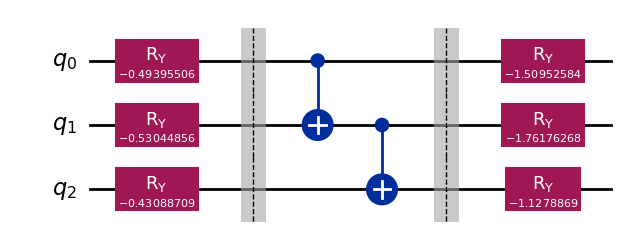

In [60]:
internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  
internal_anstaz.draw('mpl', style='iqx')

In [64]:
print(Measurement("ZII", internal_anstaz, 20000)[0])

0.2933254865482645


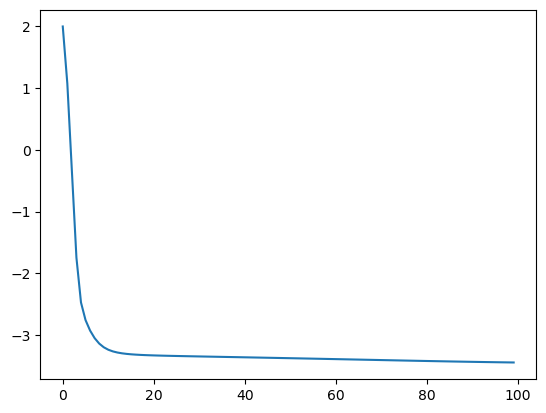

In [41]:
import matplotlib.pyplot as plt
plt.plot(intermediate_info['energy'])

# DURING REPAIR

Customize SPSA

In [ ]:
def pauli_measurement(operator, ansatz, initial_point, shots, backend):
    """ 
    operator: indicate the sum of serries of Tensor Product Pauli Operator (Hamiltonian)
    ansatz: the parameter circuit
    initial_point: the parameter for our parameter circuit
    shots: number of shots
    backend: the quantum simulator
    retun: the Hamiltonian value
    """
    internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  

    internal_energy = 0
    for j in range(len(operator)):
        internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
    return internal_energy

def Customize_SPSA(operator, interation, ansatz, initial_point, shots, backend, callback):
    """
    operator: The pauli operator
    interation: number of interation
    initial_point: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """


    # Scaling parameter for the gradient step size.
    # c = np.array([pauli_measurement(operator, ansatz, initial_point, shots, backend) for _ in range(10)]).std()
    c = 1

    # Stability constant for the step size 10% of number of interations
    A = 0.1*interation

    # Scaling exponent for the step size
    alpha = 0.602

    # Scaling exponent for the gradient step size
    gamma = 0.101

    #  Smallest change of magnitude desired in the elements of θ.
    delTheta = 0.05
    
    
    magnitude_g0 = np.abs(Customize_Parameter_Shift_Rule(operator, initial_point, c, ansatz, shots, backend, interation=None)).mean()
    # Scaling parameter for the step size
    a = delTheta*((A+1)**alpha)/magnitude_g0
    
    internal_initial_point = initial_point.copy()

    energy = []

    for k in range(interation):        
        internal_energy = pauli_measurement(operator, ansatz, internal_initial_point, shots, backend)
        print(internal_energy)
        print(internal_initial_point)
        energy.append(internal_energy)


        # Optimization part
        grad = np.zeros(ansatz.num_parameters)
        ak = a/(1+k+A)**alpha
        ck = c/(1+k)**gamma
        
        print(f'ak_{k}: {ak}')
        print(f'ck_{k}: {ck}')
        for i in range(len(operator)):
            random = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
            # print(random)
            plus_parameter = np.array(internal_initial_point.copy())
            plus_parameter = np.add(plus_parameter,random*ck)
            minus_parameter = np.array(internal_initial_point.copy())
            minus_parameter = np.subtract(minus_parameter,random*ck)
            grad_func = ak*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*ck)
            
            grad = np.add(grad, grad_func*random)
        print(f'grad: {grad}')
        internal_initial_point = np.subtract(internal_initial_point, grad)
    
    return energy


Customize QN-SPSA

In [ ]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit import Aer, execute

def SwapTest(circ1, circ2, shots, backend):
    """
    circ1: for the parameter circuit of VQD
    circ2: for the parameter circuit of VQE, this circuit have the infromation from the VQE running, or the k-1 of VQD running
    shots: number of shots
    backend: backend for running
    """

    # Perpare the circuit
    num_qubits = circ1.num_qubits
    circ = QuantumCircuit(2*num_qubits+1) # Plus one for the ancilla qubit

    circ = circ.compose(circ1, [i for i in range(1, num_qubits+1)])
    circ = circ.compose(circ2, [i for i in range(num_qubits+1, num_qubits*2+1)])
    circ.barrier()

    circ.h(0)

    for i in range(1, num_qubits+1):
        circ.cswap(0, i, i+num_qubits)

    circ.h(0) 


    # Make measurement
    measurement = ClassicalRegister(1)
    circ.add_register(measurement)
    circ.measure(0, 0)

    result = execute(circ, backend, shots=shots).result()

    counts = result.get_counts()

    overlap_value = 0

    if '1' in counts:
        # Key exists, do something with data['value']
        overlap_value = counts['1']
    else:
        # Key doesn't exist, return to default value (0 in this case)
        overlap_value = 0
    
    overlap_value = 1 - 2*overlap_value/shots

    

    
    return overlap_value, circ

def Customize_QN_SPSA(operator, interation, ansatz, initial_point, shots, backend, callback):
    """
    operator: The pauli operator
    interation: number of interation
    initial_point: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """


    # Scaling parameter for the gradient step size.
    # c = np.array([pauli_measurement(operator, ansatz, initial_point, shots, backend) for _ in range(10)]).std()
    # c = 0.08
    c = 1

    # Stability constant for the step size 10% of number of interations
    A = 0.1*interation

    # Scaling exponent for the step size
    alpha = 0.602

    # Scaling exponent for the gradient step size
    gamma = 0.101

    #  Smallest change of magnitude desired in the elements of θ.
    # delTheta = 0.001
    delTheta = 0.05
    
    
    magnitude_g0 = np.abs(Customize_Parameter_Shift_Rule(operator, initial_point, c, ansatz, shots, backend, interation=None)).mean()
    # Scaling parameter for the step size
    a = delTheta*((A+1)**alpha)/magnitude_g0
    # a = 0.001

    #  regularization coefficient
    beta = 0.05
    
    internal_initial_point = initial_point.copy()

    energy = []

    regularized_fubini_matrix_previous = np.zeros((ansatz.num_parameters, ansatz.num_parameters))

    for k in range(interation):        
        internal_energy = pauli_measurement(operator, ansatz, internal_initial_point, shots, backend)
        print(internal_energy)
        print(internal_initial_point)
        energy.append(internal_energy)

        grad = np.zeros(ansatz.num_parameters)
        # SPSA part
        gradSPSA = np.zeros(ansatz.num_parameters)
        ak = a/(1+k+A)**alpha
        # ak = 0.001
        ck = c/(1+k)**gamma
        # ck = 0.05
        
        print(f'ak_{k}: {ak}')
        print(f'ck_{k}: {ck}')
        for i in range(len(operator)):
            random = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
            # print(random)
            plus_parameter = np.array(internal_initial_point.copy())
            plus_parameter = np.add(plus_parameter,random*ck)
            minus_parameter = np.array(internal_initial_point.copy())
            minus_parameter = np.subtract(minus_parameter,random*ck)
            grad_func = operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*ck)
            
            gradSPSA = np.add(gradSPSA, grad_func*random)
        
        print(f'gradSPSA {gradSPSA}')

        
        # Natural Gradient Part
        random1 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
        random2 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
        initial_plus1_plus2 = np.add(initial_point, np.add(ck*random1, ck*random2))
        initial_plus1 = np.add(initial_point, ck*random1)
        initial_minus1_plus2 = np.subtract(initial_point, np.subtract(ck*random1, ck*random2))
        initial_minus1 = np.subtract(initial_point, ck*random1)

        ansatz_initial = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_plus1_plus2 = ansatz.bind_parameters({theta: initial_plus1_plus2[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_plus1 = ansatz.bind_parameters({theta: initial_plus1[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_minus1_plus2 = ansatz.bind_parameters({theta: initial_minus1_plus2[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_minus1 =  ansatz.bind_parameters({theta: initial_minus1[k] for k, theta in enumerate(ansatz.parameters)})  

        deltaF = SwapTest(ansatz_initial, ansatz_plus1_plus2, shots, backend)[0] - SwapTest(ansatz_initial, ansatz_plus1, shots, backend)[0] -SwapTest(ansatz_initial, ansatz_minus1_plus2, shots, backend)[0] + SwapTest(ansatz_initial, ansatz_minus1, shots, backend)[0]

        # Fubini_matrix
        fubini_matrix = -1/2*(deltaF/(2*ck**2))*(np.array(np.array([random1]).T*random2) + np.array(np.array([random2]).T*random1))/2
        
        # Data of previous regularized study metric
        exponentially_smoothed_fubini = k/(k+1)*regularized_fubini_matrix_previous + 1/(k+1)*fubini_matrix.copy()

    
        regularized_fubini_matrix = np.add(np.power(exponentially_smoothed_fubini*exponentially_smoothed_fubini, 1/2), beta*np.identity(ansatz.num_parameters))

        regularized_fubini_matrix_previous = regularized_fubini_matrix

        # print(f'regularized_fubini_matrix---{regularized_fubini_matrix}')

        grad = ak*np.linalg.pinv(regularized_fubini_matrix).dot(gradSPSA)

        print(f'grad: {grad/ak}')
        print(f'parameter {internal_initial_point}')
        internal_initial_point = np.subtract(internal_initial_point, grad)
    
    return energy